In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

From the EDA notebook, we found that zipcode 11222 was one of the top 5 zipcodes. We are going to forecast future home values in zipcode 11222 in this notebook.

## Import Data

Import the same data that we used in the EDA notebook.

In [2]:
df = pd.read_csv('zillow_data.csv')

Change RegionName column name to Zipcode for easier read.

In [3]:
df = df.rename(columns={'RegionName': 'Zipcode'})

Created a function to melt the data.

In [4]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'Zipcode', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Create melted dataframe with just the zipcode 11222.

In [5]:
df_11222 = melt_data(df[df['Zipcode'] == 11222])

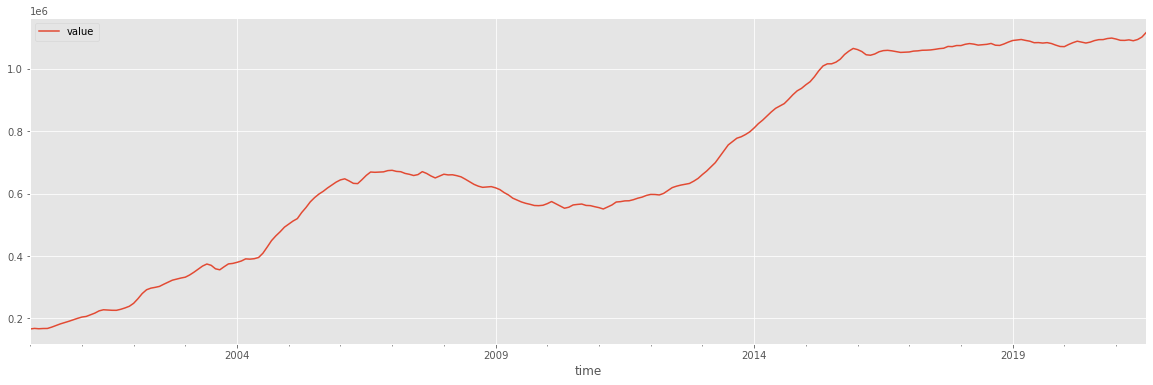

In [6]:
df_11222.plot(figsize=(20,6));

## Baseline Model

For our baseline model, we will take the dataset with just one shift backwards.

In [7]:
naive = df_11222.shift(1)
naive

,value
time,
2000-01-31,NaN
2000-02-29,166164.0
2000-03-31,167963.0
2000-04-30,166884.0
2000-05-31,167666.0
...,...
2021-04-30,1091475.0
2021-05-31,1093203.0
2021-06-30,1090352.0


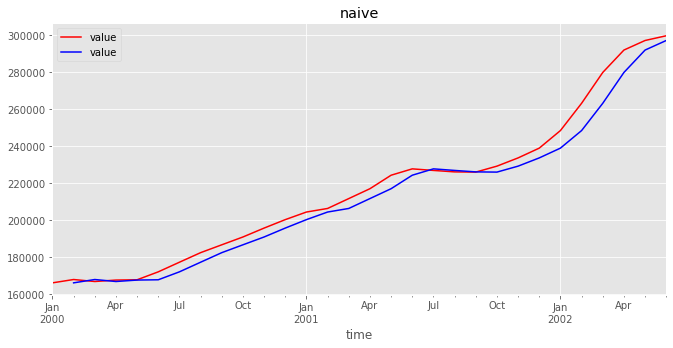

In [8]:
fig, ax = plt.subplots(figsize=(11, 5))

df_11222[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [9]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.232076
p-value                          0.659648
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


## Modeling

In [10]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

dftest = adfuller(df_11222)

dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                  -1.113941
p-value                          0.709480
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64

adfuller test shows that the p-value > 0.05. So that means that we fail to reject the null hypothesis and the model is not stationary.

Now, we need to make our model become stationary.

## Check seasonality

We can check for trends, seasonality, and residuals using seasonal_decompose function.

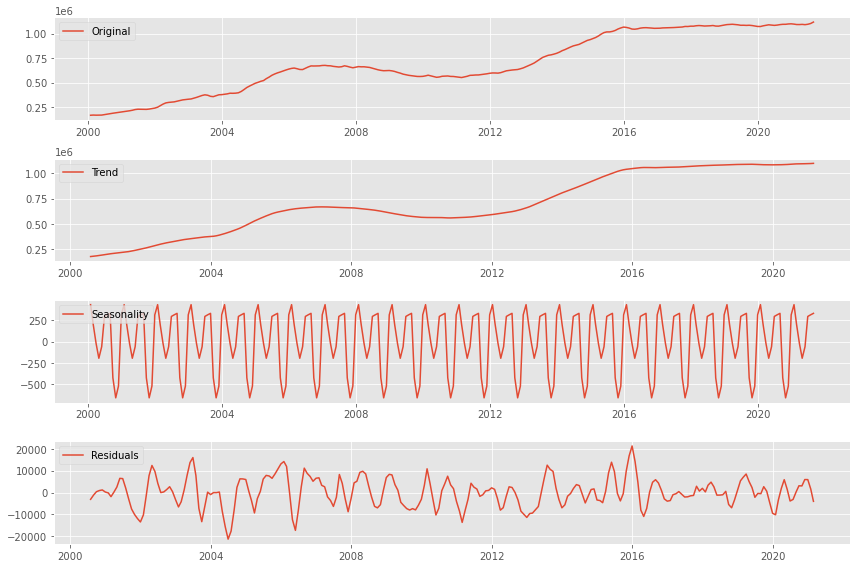

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_11222)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_11222, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

The model has an upward trend with seasonality as well.

## Differencing

We can try to make our model stationary by taking the difference.

In [12]:
diff = df_11222.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -5.025123
p-value                          0.000020
#Lags Used                      14.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


Taking two difference makes our p-value < 0.05. Let's look at autocorrelation.

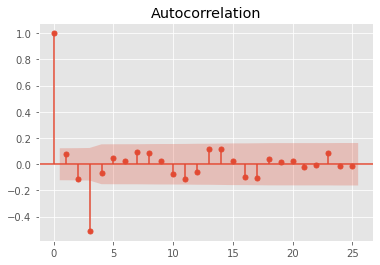

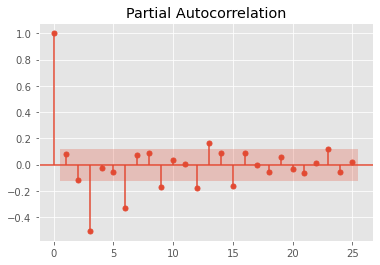

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Plot
plot_acf(df_11222.diff().diff().dropna());

# Partial Autocorrelation Plot
plot_pacf(df_11222.diff().diff().dropna());

In [14]:
import warnings
warnings.filterwarnings("ignore")

## SARIMAX

We can make start modeling with our data using SARIMAX. 

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

To get the best hyperparameters for our model, we created a combination of orders and seasonal orders in the range of 0-2, inclusive.

In [16]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [17]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_11222,
                         order=comb,
                         seasonal_order=combs,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7749.231456538554
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7239.822516260577
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =6880.6640155847945
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6240.946550138509
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5856.435290509642
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5503.622854827247
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5786.755076223748
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =5497.975262277894
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =5211.454154257997
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6204.5479561105
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6106.875832157964
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5760.553970881423
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5777.587189845715
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7734.060746891823
ARIMA (0, 0, 0) x (1,

ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4677.576806424087
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4773.633024756832
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4718.17324326317
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4475.049805460118
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4703.272947448826
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4533.435624788357
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4355.528012604298
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4703.244177775849
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4722.752772996733
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4679.481882016565
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4517.4591477503
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4517.252989051792
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4477.049801248015
ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =4425.478783317629
ARIMA (0, 1, 1) x (2, 2

ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4460.945209417378
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4457.928684699071
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4398.712400048072
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4402.598290308819
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =4380.4591428922095
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =4318.785021404997
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5319.969520143485
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5400.025873897634
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =5124.108392337786
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5138.909587907729
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4900.611695260413
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4597.557874008817
ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5123.353156578116
ARIMA (1, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4878.477519331655
ARIMA (1, 0, 0) x (

ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4662.317550633522
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4407.079040962841
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4955.135261021676
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4588.085898475363
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =4314.706731501561
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4812.955788434584
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4794.701357929576
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4567.882862570574
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4673.0660427651055
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4653.526984965739
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4409.0672111480435
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4630.1813006071625
ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4566.009247137799
ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4313.562060567467
ARIMA (1, 1, 1) x

ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4385.640786578171
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4640.707048920121
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4564.907717498454
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4311.119221596524
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4559.633534845661
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4560.081777796287
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4522.901460415348
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =4425.912800229616
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =4424.515559864821
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4385.869116667709
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =4368.710321584109
ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =4352.05234782711
ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =4311.835149705041
ARIMA (2, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5037.46349218892
ARIMA (2, 0, 0) x (0, 

ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =4326.81555708294
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =4301.534692369918
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =4302.441268562141
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =5016.902897252583
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4794.235629284079
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4567.072902303144
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4934.045836936434
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4658.350253907774
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4404.5232906863
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4942.707193129547
ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4575.754992078999
ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =4304.279985640909
ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4794.244658623569
ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4794.912220497343
ARIMA (2, 1, 1) x (1, 0

ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =4577.7254248956315
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =4307.863634960785
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4749.559767088063
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4725.315229700963
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =4502.006131649412
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4642.577450220699
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =4621.372740287131
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4375.074984195917
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4616.959975307841
ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =4563.89304508741
ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =4308.056716478744
ARIMA (2, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =4521.553340850711
ARIMA (2, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4521.099559187063
ARIMA (2, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =4503.969759958603
ARIMA (2, 2, 2) x (2

In [18]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (2, 2, 1, 12)
aic       4228.479308
Name: 376, dtype: object

From the combination, our SARIMAX model with order=(1,1,1) and seasonal_order=(2, 2, 1, 12) got the lowest aic score, which was 4228.479308.

Now, we can use those hyperparameters for our final model to predict future home values.

In [19]:
import statsmodels.api as sm

# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_11222, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(2, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7405      0.057     12.988      0.000       0.629       0.852
ma.L1          0.1185      0.085      1.395      0.163      -0.048       0.285
ar.S.L12      -0.6578      0.055    -11.952      0.000      -0.766      -0.550
ar.S.L24      -0.3121      0.067     -4.666      0.000      -0.443      -0.181
ma.S.L12      -0.7827      0.018    -43.821      0.000      -0.818      -0.748
sigma2      3.022e+07   2.53e-10   1.19e+17      0.000    3.02e+07    3.02e+07


From the summary table, we can see that most of the weight has a p-value lower or close to 0.05.

Next, we ran model diagnostics to ensure that none of the assumptions made by the model have been violated.

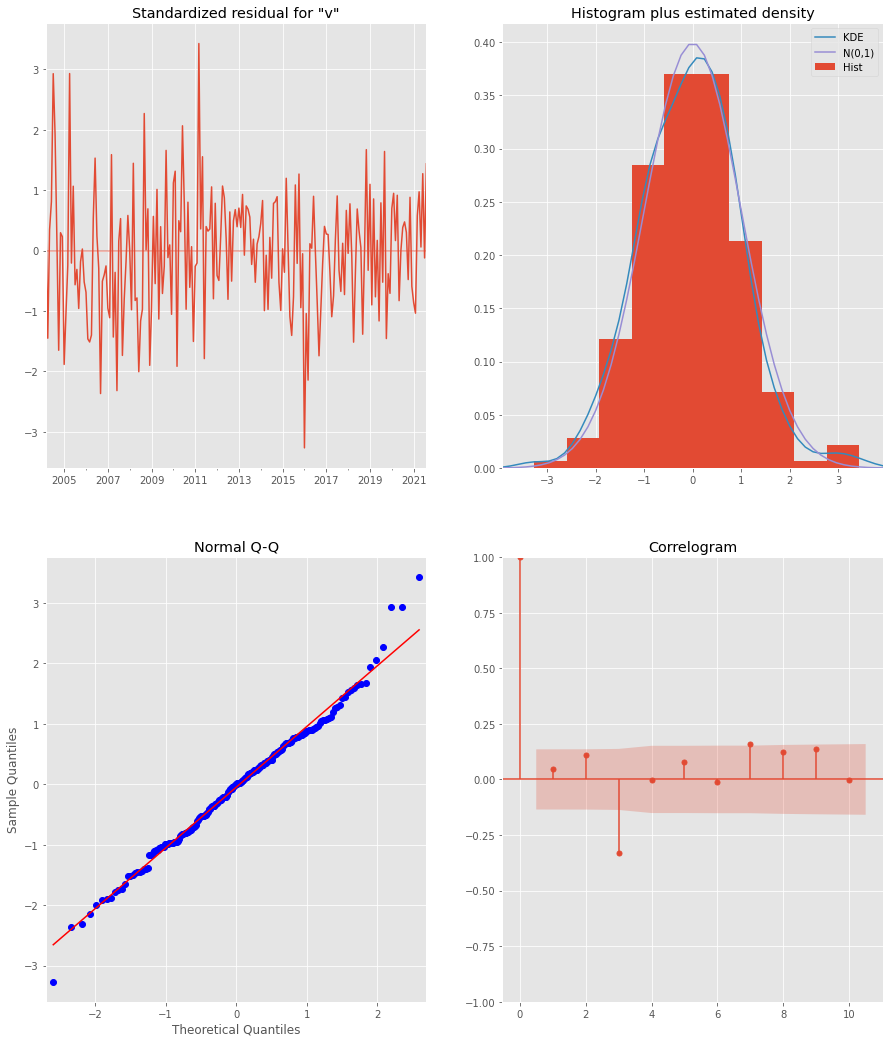

In [20]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The first plot shows that the some residuals are normally distributed. The top right plot shows that the data seems normally distributed. The bottom left plot shows that the residuals follow the linear trend from a standard normal distribution. The bottom right plot shows that the autocorrelation.

## Validating the Model

We will now validate the model by comparing predicted values to real values.

We will validate last two years, starting from 2019-01-31.

In [21]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

With the predicted values, we can plot the real and forecasted home values.

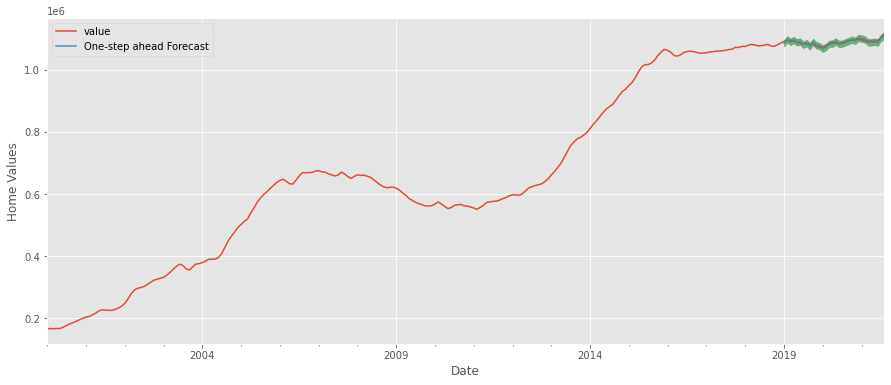

In [22]:
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_11222.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show()

The forecasts align with the true values as seen above, with overall increase trend.

We will check for the accuracy of our forecasts using RMSE (Root Mean Squared Error).

In [23]:
# Get the real and predicted values
value_forecasted = pred.predicted_mean
value_truth = df_11222['value']['2019-01-31':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4622.03


## Dynamic Forecasting

Let's try to achieve a deep insight by using dynamic forecasts.

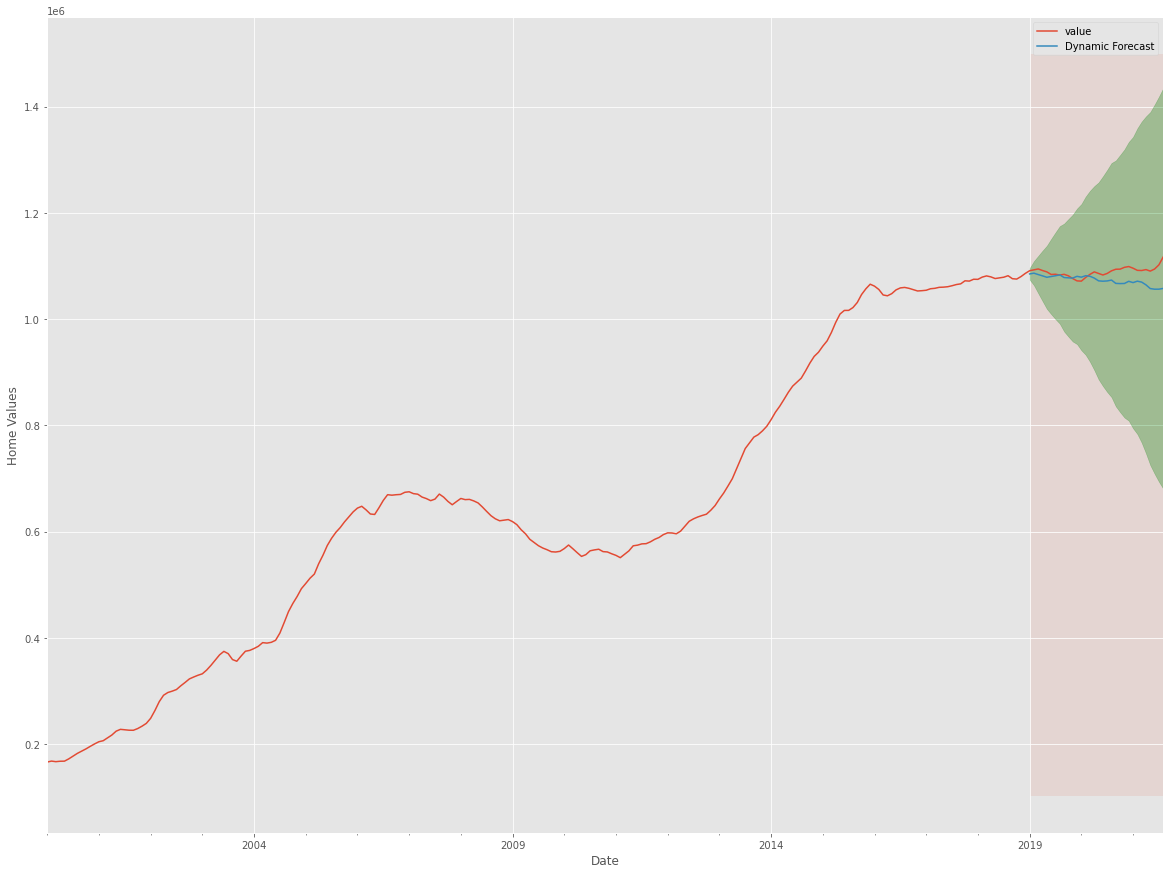

In [24]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.
ax = df_11222.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

plt.legend()
plt.show();

In [25]:
# Extract the predicted and true values of our time series
value_forecasted = pred_dynamic.predicted_mean
value_truth = df_11222['value']['2019-01-31':]

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 21868.92


The RMSE score is lower here than what we got before.

## Producing and Visualizing Forecasts

Now, we will forecast future home values

In [26]:
# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

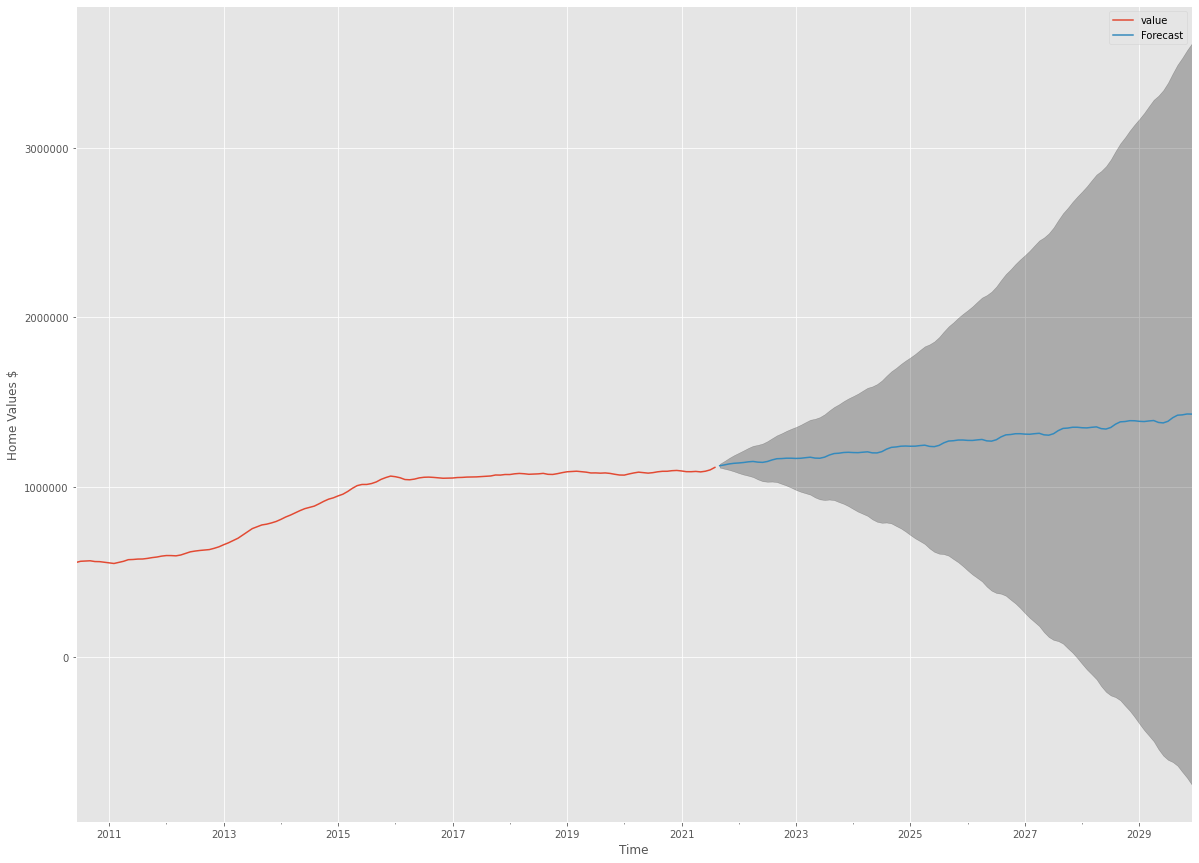

In [27]:
# Plot future predictions with confidence intervals
ax = df_11222.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Time')
ax.set_ylabel('Home Values $')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show();

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the dataset for zipcode 11222 and foresee what to expect. We get less confident as we go more into the future.